In [1]:
import hydra
from src.commons.constants import PROJECT_PATH
from omegaconf import DictConfig, OmegaConf

import numpy as np
import cv2
from PIL import Image
import torch
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from torch.utils import data
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import hydra
import torch
from omegaconf import DictConfig, OmegaConf

from sklearn.manifold import TSNE # new
from sklearn.decomposition import PCA
import seaborn as sns

from src.commons.utils_io import load_sam, make_path, check_dir
from src.commons.utils import *
from src.models.commons.mask_process import extract_object_from_batch, binarize_mask
from src.commons.constants import *
from src.data.loader import BiTemporalDataset
from src.data.process import generate_grid_prompt, DefaultTransform
from src.models.magic_pen.task import MagicPenModule
from src.models.segment_any_change.model import BiSam
from src.models.segment_any_change.mask_generator import SegAnyMaskGenerator
from src.models.commons.mask_items import ImgType


Welcome in JZAY


In [2]:
from torch.nn.utils.rnn import pad_sequence
from src.models.commons.mask_process import extract_object_from_batch

In [3]:
def load_config():
    # Initialize the Hydra configuration
    hydra.initialize(config_path="../configs", version_base=None)
    
    # Compose the configuration with the desired environment override
    cfg = hydra.compose(
        config_name="eval", 
        overrides=["experiment=seganychange_matching", 
                   "sam_type=small", 
                   "data=levir-cd",
                  ])
    
    return cfg
from hydra.core.global_hydra import GlobalHydra

def get_dloader(mode: str, dmodule):

    def wrap_mode(mode):
        if mode == "train":
            return "fit"
        return mode
    if not dmodule.ds_dict_type:
        mode_ = wrap_mode(mode)
        dmodule.setup(mode_)
    factory_dl = {
        "train": dmodule.train_dataloader,
        "val": dmodule.val_dataloader,
        "test": dmodule.test_dataloader,
    }
    return factory_dl[mode]()
    
GlobalHydra.instance().clear()
cfg = load_config()

In [4]:
data_module = hydra.utils.instantiate(cfg.data)
dloader = get_dloader("test", data_module)

In [5]:
batch = next(iter(dloader))

In [6]:
batch.keys()

dict_keys(['img_A', 'img_B', 'label', 'label_path', 'index', 'point_coords', 'point_labels'])

In [7]:
# seganychange model
sam_arch = cfg.sam_enc_arch.replace("-", "_")
bisam = load_sam(
    model_type=sam_arch, model_cls=BiSam, version= "dev", device="cpu"
)

2024-08-22 22:46:29,492 - INFO ::  build vit_b BiSam


INIT VIT


In [9]:
from src.data.process import PointSampler

n_shape = 60
b_points = []
b_labels = []

for i in range(cfg.data.params.batch_size):

    pt, lab = PointSampler().sample(mask=batch["label"][i], n_point_per_shape=1, loc="center", n_shape=n_shape)
    b_points.append(pt)
    b_labels.append(lab)

batch["point_coords"] = pad_sequence(b_points, batch_first=True) 
batch["point_labels"] = pad_sequence(b_labels, batch_first=True) 

shape torch.Size([12, 1024, 1024])
shape torch.Size([48, 1024, 1024])


In [10]:
from src.models.segment_any_change.query_prompt import QueryPointMecanism
from src.models.segment_any_change.model import SamModeInference
outputs = bisam(
            batched_input=batch,
            multimask_output=True,
            return_logits=True,
            mode=SamModeInference.INTERACTIVE,
        )

queryprompt = QueryPointMecanism(None, None, None)
new_masks, iou_predictions = outputs.values()
new_masks = (new_masks > 0.0).to(torch.uint8)
best_masks, best_ious = queryprompt.get_best_masks(new_masks, iou_predictions)

sparse_embeddings: torch.Size([2, 48, 2, 256])
dense_embeddings: torch.Size([2, 48, 256, 64, 64])


In [11]:
torch.sum(best_masks[1], dim=(-2, -1))

tensor([ 70, 108,  83,  76,  82, 151,  63,  97,  23,  81,  72,  75,  78,  80,
         63,  84,  88,  90,  80,  55,  88,  76,  71,  98,  96,  71,  88,  86,
         72,  89,  91,  74,  68, 115,  74,  96,  72,  94,  91, 102,  93,  88,
         81,  66,  43,  95,  91,  80])

In [12]:
batch["point_coords"][0].shape

torch.Size([48, 2])

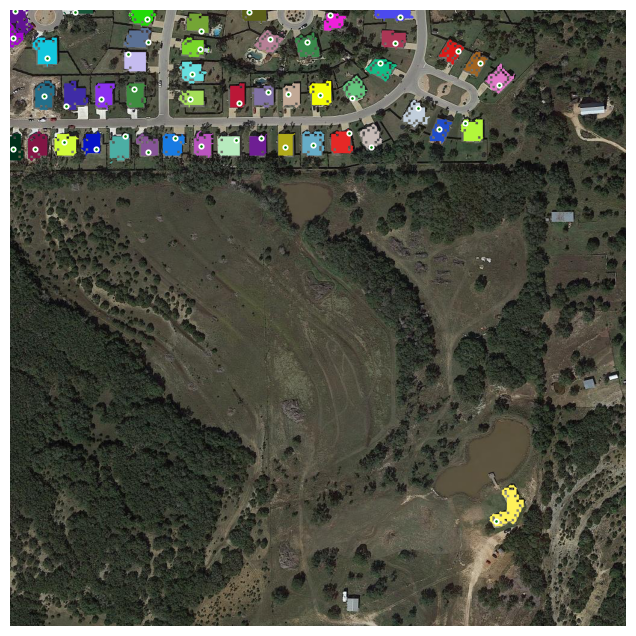

In [15]:
idx = 1
masks = best_masks[idx].clone()
masks = resize(best_masks, batch["img_B"][idx].shape[-2:]).to(torch.uint8)[idx]
# image = resize(batch["img_B"], best_masks.shape[-2:]).to(torch.uint8)[idx]
image = batch["img_B"][idx]
image = to_numpy(image)

# Generate random colors for each mask
colors = np.random.randint(0, 256, (60, 3), dtype=np.uint8)

# Copy the original image to overlay the masks
overlay_image = image.copy()

# Apply each mask to the image
for i in range(masks.shape[0]):
    mask = masks[i].numpy()  # Convert to numpy array if needed
    for c in range(3):  # Apply the color to each channel (R, G, B)
        overlay_image[:, :, c] = np.where(mask == 1, colors[i, c], overlay_image[:, :, c])

# Plot the original image and the image with masks applied
plt.figure(figsize=(8, 8))
plt.imshow(overlay_image / 255)
plt.axis('off')
ax = plt.gca()
ax.scatter(
    batch["point_coords"][idx][:, 0],
    batch["point_coords"][idx][:, 1],
    color="green",
    marker="o",
    s=10,
    edgecolor="white",
    linewidth=1.25,
)